In [1]:
pip install mne

     |████████████████████████████████| 7.5 MB 4.8 MB/s 


In [20]:
import os
import numpy as np
import mne

#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Visual
import matplotlib.pyplot as plt
from mne.preprocessing import (ICA, corrmap)
from scipy.stats import ttest_rel
from tensorflow.keras import utils as np_utils
from sklearn.utils import shuffle
import seaborn as sns

#CNN
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [3]:
dataPath = '/content/drive/MyDrive/databbci'

In [5]:
import os

active = []
passive = []
cue = []


data_number = 0
for dir in os.listdir(dataPath):
  for filename in os.listdir(os.path.join(dataPath, dir)):
    #if filename.endswith(".vhdr"):
    tmp = os.path.join(os.path.join(dataPath, dir), filename)
      #with open(os.path.join(os.path.join(dataPath, dir), filename), 'r') as f: # open in readonly mode
    if filename.endswith("active.vhdr"):
      active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("passive.vhdr"):
      passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
    elif filename.endswith("cue.vhdr"):
      cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
print(len(active))

<ipython-input-5-e82f2427b298>:17: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  passive.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-5-e82f2427b298>:15: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  active.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-5-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-5-e82f2427b298>:19: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  cue.append(mne.io.read_raw_brainvision(tmp, preload=True, verbose=False))
<ipython-input-5-e82f2427b298>:17: RuntimeWarning: Online software filter detected. Using software filter setting

3


# Function | Run All

    func: raw_to_data(raw, non_active = 0) 
    * active = 0
    * passive = 1
    * cue = 2
    return X, y

\-

    def get_train_test(act, pas, cue): 
    * active[subject] -> act
    * call function "raw_to_data"
    return train_X, test_X, train_y, test_y

\- LDA

  
    def lda_101(train_X, test_X, train_y, test_y):
    return clf, cm

\- CNN

    def cnn_101(train_X, test_X, train_y, test_y):
    * batch_size = 16
    * epochs = 100
    * num_classes = 2
    return cnn_model, cnn_train, test_eval, cm_cnn


\- Visualization

    def vis_confusion_matrix(cm):
    * plot 


## All data load

In [46]:
def raw_to_data(raw, non_active = 0):
  raw.pick_channels(['C1', 'Fz', 'C2', 'F3', 'F4', 'Pz', 'Oz', 'C3', 'Cz', 'C4'])
  raw.filter(l_freq=0.4, h_freq=40, fir_design='firwin', verbose=False)
  #raw.filter(l_freq=0.4, h_freq=40, method = 'iir', verbose=False)

  events, _ = mne.events_from_annotations(raw, verbose=False)
  tmin, tmax = -0., 1.  # in s
  baseline = (None, 0)

  #passive -> ignore 
  #cue -> active
  # -> active, ignore
  event_dict = {'active': 1, 'ignore': 2}
  if non_active != 0:
    event_dict.clear()
    if non_active == 1: #passive
      event_dict = {'ignore': 2}
    else: # cue
      event_dict = {'active': 1}
  
  epochs = mne.Epochs(
    raw, events=events,
    event_id=event_dict, tmin=tmin,
    tmax=tmax, baseline=None, preload = True, verbose=False)
  # print(epochs.events.size)
  # print(epochs.event_id)
  # {'active': 1, 'ignore': 2}

  #preprocessing
  filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
  ica = ICA(n_components=10, max_iter='auto', random_state=97)
  ica.fit(epochs)

  X = epochs.get_data()*1000  # MEG signals: n_epochs, n_meg_channels, n_times
  y = epochs.events[:, 2]  # target: auditory left vs visual left
  #print(X.shape, y.shape)

  return X, y

## Preprocessing

In [47]:
def get_train_test(act, pas, cue):
  subject = 0
  train_X, train_y = raw_to_data(act, 0)
  pas_X, pas_y = raw_to_data(pas, 1) #passive = 1
  cue_X, cue_y = raw_to_data(cue, 2) #ignore = 2

  test_X = np.append(cue_X, pas_X, axis = 0)
  test_y = np.append(cue_y, pas_y, axis = 0)

  return train_X, test_X, train_y, test_y


## LDA Function

In [48]:
def lda_101(train_X, test_X, train_y, test_y):
  train_lda = train_X.reshape(540,-1)
  n, _, _ = test_X.shape
  test_lda = test_X.reshape(n, -1)

  clf = LDA()
  clf.fit(train_lda, train_y)

  y_pred = clf.predict(test_lda)
  cm = confusion_matrix(test_y, y_pred)
  print(cm)
  print('Accuracy' + str(accuracy_score(test_y, y_pred)))

  return clf, cm

## CNN Functions

In [274]:
def cnn_101(train_X, test_X, train_y, test_y, batch_size = 32, epochs = 100):
  train_X = train_X.reshape(-1, 10,101, 1)
  test_X = test_X.reshape(-1, 10,101, 1)

  #train_X, train_y = shuffle(test_X, test_y, random_state=2)
  #test_X, test_y = shuffle(test_X, test_y, random_state=2)
  
  train_X,valid_X,train_label,valid_label = train_test_split(train_X, 
                                                             train_y, 
                                                             test_size=0.2, 
                                                             random_state=13)

  train_label_categorical = np_utils.to_categorical(train_label-1)
  valid_label_categorical = np_utils.to_categorical(valid_label-1)
  test_y = np_utils.to_categorical(test_y-1)

  # batch_size = 32
  # epochs = 100
  num_classes = 2

  cnn_model = Sequential()
  cnn_model.add(Conv2D(8, kernel_size=(40, 4),activation='relu',input_shape=(10,101,1),padding='same'))
  # cnn_model.add(MaxPooling2D((2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(16, (80, 4), activation='relu',padding='same'))
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Conv2D(32, (80, 4), activation='relu',padding='same'))         
  # cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(0.25))

  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dense(num_classes, activation='sigmoid'))

  # set a valid path for your system to record model checkpoints
  checkpointer = ModelCheckpoint(filepath='/tmp/checkpoint.h5', verbose=1,
                               save_best_only=True)
  
  y_integers = np.argmax(train_label_categorical, axis=1)
  class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
  d_class_weights = dict(enumerate(class_weights))

  opt = SGD(lr=0.01)
  #opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

  cnn_model.compile(optimizer=opt,
          loss = "categorical_crossentropy",
          metrics=['accuracy'])
  
  cnn_train = cnn_model.fit(train_X, train_label_categorical, batch_size=batch_size, 
                          epochs=epochs,
                          verbose=1,
                          validation_data=(valid_X, valid_label_categorical), 
                          callbacks=[checkpointer], 
                          class_weight = d_class_weights
                          )

  test_eval = cnn_model.evaluate(test_X, test_y, verbose=0)

  pred_prob_conv = cnn_model.predict(test_X)

  pred_y_conv = np.argmax(pred_prob_conv, axis=1)  # only necessary if output has one-hot-encoding, shape=(n_samples)
  test_y_conv = np.argmax(test_y, axis=1)

  cm_cnn = cm_cnn = metrics.confusion_matrix(y_true=test_y_conv, 
                                              y_pred=pred_y_conv)

  return cnn_model, cnn_train, test_eval, cm_cnn


In [50]:
def vis_acc_loss(cnn_train):
  accuracy = cnn_train.history['accuracy']
  val_accuracy = cnn_train.history['val_accuracy']
  loss = cnn_train.history['loss']
  val_loss = cnn_train.history['val_loss']
  epochs = range(len(accuracy))
  plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
  plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

## Visualization Functions

In [51]:
def vis_confusion_matrix(cm):


  ax = sns.heatmap(cm, annot=True, 
            fmt='', cmap='Blues')
  
  # group_counts = ["{0:0.0f}".format(value) for value in
  #                 confusion_matrix.flatten()]

  # labels = [f"{v1}\n" for v1 in zip(group_counts)]

  # labels = np.asarray(labels).reshape(2,2)
  
  ax.set_title('CNN Confusion Matrix \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['NI','AC'])
  ax.yaxis.set_ticklabels(['NI','AC'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()


# Test | All Subjects

In [52]:
cnn_models = []
lda_models = []

## Test: LDA & CNN | Subject 1

In [259]:
subject = 0

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.0s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

LDA

In [261]:
clf_lda, cm_lda = lda_101(tune_tX, tune_tsX, train_y, test_y) 
lda_models.append(clf_lda)

[[ 64  36]
 [ 75 105]]
Accuracy0.6035714285714285


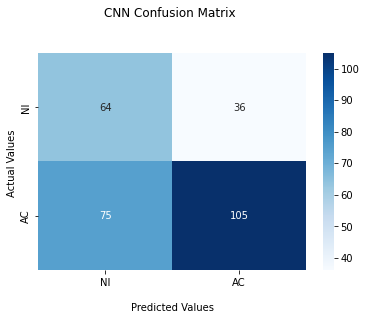

In [262]:
vis_confusion_matrix(cm_lda)

CNN

In [273]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_101(tune_tX, 
                                                  tune_tsX, 
                                                  train_y, 
                                                  test_y,
                                                  batch_size = 16,
                                                  epochs = 50)

cnn_models.append(cnn_model)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


27/27 [==============================] - ETA: 0s - loss: 1.9412 - accuracy: 0.5486
Epoch 1: val_loss improved from inf to 0.69862, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 29s 1s/step - loss: 1.9412 - accuracy: 0.5486 - val_loss: 0.6986 - val_accuracy: 0.3333
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.5440
Epoch 2: val_loss improved from 0.69862 to 0.68087, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 28s 1s/step - loss: 0.6867 - accuracy: 0.5440 - val_loss: 0.6809 - val_accuracy: 0.6667
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.6042
Epoch 3: val_loss improved from 0.68087 to 0.67245, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 28s 1s/step - loss: 0.6799 - accuracy: 0.6042 - val_loss: 0.6724 - val_accuracy: 0.6667
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.6543 - accuracy

KeyboardInterrupt: ignored

In [ ]:
cnn_model.save("cnn_model_1.h5py")

INFO:tensorflow:Assets written to: cnn_model.h5py/assets


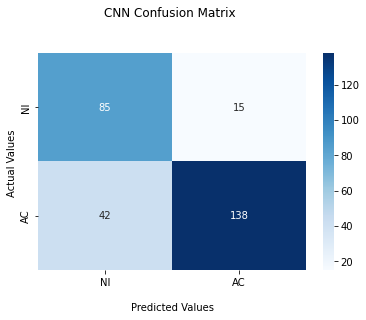

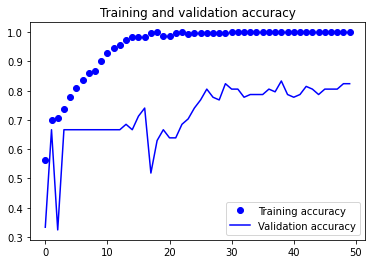

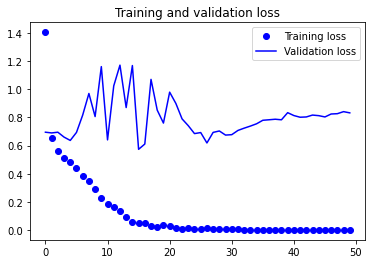

In [249]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [250]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.796666145324707
Test accuracy: 0.7964285612106323


## LDA & CNN | Subject 2

In [275]:
subject = 1

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.0s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

In [54]:
test_X.shape

(280, 10, 101)

[[47 53]
 [89 91]]
Accuracy0.4928571428571429


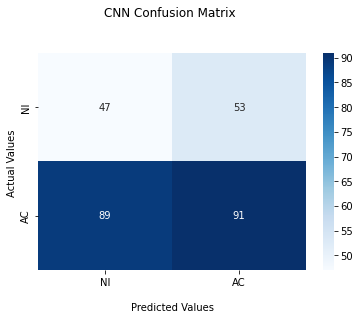

In [277]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

[[47 53]
 [89 91]]
Accuracy0.4928571428571429


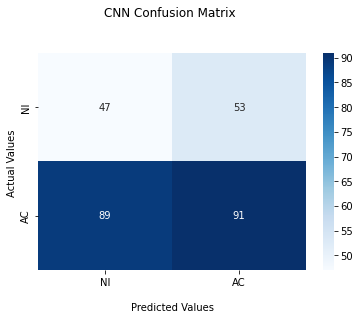

In [278]:
clf_lda, cm_lda = lda_101(tune_tX, tune_tsX, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [279]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_101(train_X, 
                                                  test_X, 
                                                  train_y, 
                                                  test_y)

cnn_models.append(cnn_model)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


14/14 [==============================] - ETA: 0s - loss: 2.0709 - accuracy: 0.5486
Epoch 1: val_loss improved from inf to 0.69797, saving model to /tmp/checkpoint.h5
14/14 [==============================] - 29s 2s/step - loss: 2.0709 - accuracy: 0.5486 - val_loss: 0.6980 - val_accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.6481
Epoch 2: val_loss did not improve from 0.69797
14/14 [==============================] - 27s 2s/step - loss: 0.6859 - accuracy: 0.6481 - val_loss: 0.7275 - val_accuracy: 0.3333
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.6944
Epoch 3: val_loss did not improve from 0.69797
14/14 [==============================] - 27s 2s/step - loss: 0.5839 - accuracy: 0.6944 - val_loss: 0.7192 - val_accuracy: 0.3333
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.7500
Epoch 4: val_loss did not improve from 0.69797
14/14 [==============

In [280]:
cnn_model.save("cnn_model_2.h5py")

INFO:tensorflow:Assets written to: cnn_model_2.h5py/assets


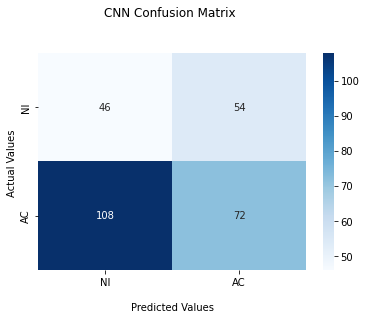

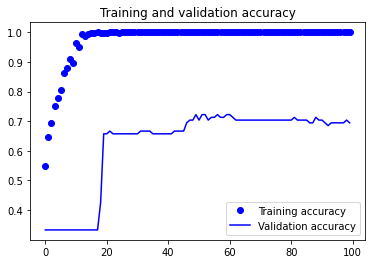

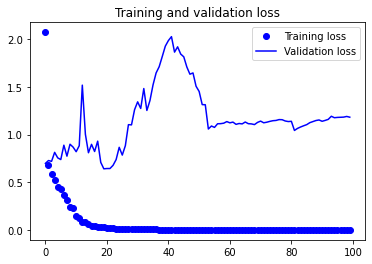

In [281]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

## Test 3: LDA & CNN | Subject 3

In [282]:
subject = 2

train_X, test_X, train_y, test_y = get_train_test(active[subject], passive[subject], cue[subject])

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 sec)

Fitting ICA to data using 10 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 1.3s.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- F

[[44 56]
 [75 75]]
Accuracy0.476


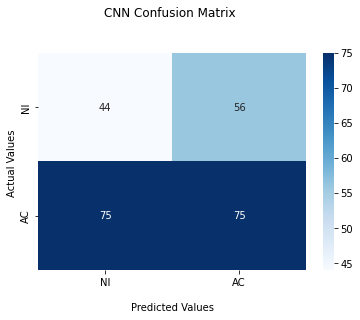

In [284]:
clf_lda, cm_lda = lda_101(train_X, test_X, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

[[40 60]
 [67 83]]
Accuracy0.492


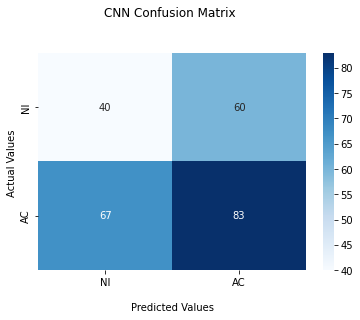

In [285]:
clf_lda, cm_lda = lda_101(tune_tX, tune_tsX, train_y, test_y) 
lda_models.append(clf_lda)
vis_confusion_matrix(cm_lda)

In [286]:
cnn_model, cnn_train, test_eval, cm_cnn = cnn_101(tune_tX, 
                                                  tune_tsX, 
                                                  train_y, 
                                                  test_y, 16 , 50)

cnn_models.append(cnn_model)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


27/27 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.7361
Epoch 1: val_loss improved from inf to 0.67712, saving model to /tmp/checkpoint.h5
27/27 [==============================] - 42s 2s/step - loss: 0.8425 - accuracy: 0.7361 - val_loss: 0.6771 - val_accuracy: 0.7037
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.8287
Epoch 2: val_loss did not improve from 0.67712
27/27 [==============================] - 37s 1s/step - loss: 0.4457 - accuracy: 0.8287 - val_loss: 0.7462 - val_accuracy: 0.2963
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8218
Epoch 3: val_loss did not improve from 0.67712
27/27 [==============================] - 28s 1s/step - loss: 0.3769 - accuracy: 0.8218 - val_loss: 0.7292 - val_accuracy: 0.2963
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.3721 - accuracy: 0.8287
Epoch 4: val_loss did not improve from 0.67712
27/27 [=================

In [287]:
cnn_model.save("cnn_model_3.h5py")

INFO:tensorflow:Assets written to: cnn_model_3.h5py/assets


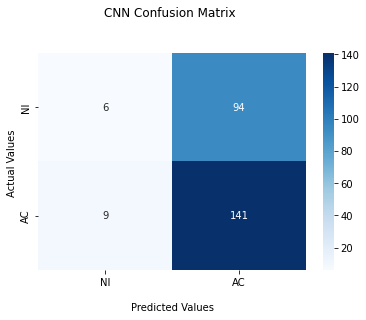

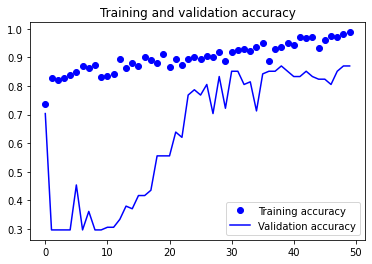

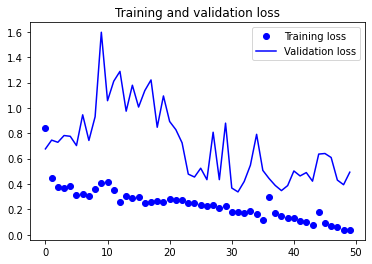

In [288]:
vis_confusion_matrix(cm_cnn)

vis_acc_loss(cnn_train)

In [76]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 3.7785305976867676
Test accuracy: 0.5839999914169312


# Tune Autoencoder

In [283]:
tX, tsX, ty, tsy = train_X.copy(), test_X.copy(), train_y.copy(), test_y.copy()

#threshold active vs threshold non intention
th_ac = np.zeros([10,101])
th_ni = np.zeros([10,101])
#print(th_ac)

#set threshold
for n in range(ty.size):
  if ty[n] == 1:
    th_ac = th_ac + tX[n]
  else:
    th_ni = th_ni + tX[n]

th_ac = th_ac/np.count_nonzero(ty == 1)
th_ni = th_ni/np.count_nonzero(ty == 2)

#difference 
#formula |x1 - x2|/((x1 + x2)/2) = 0~1

#sample 
#check true or false 
# true_value = 0
# false_value = 0

dec = np.arange(0.0, 3.1, 0.1)/10
great_value = 0

#save there the end value
tune_tX = np.zeros(tX.shape)

for k in dec:
  true_value = 0
  false_value = 0
  tmp_tX = np.zeros(tX.shape)
  
  for n in range(ty.size):
    ac = np.absolute(tX[n] - th_ac)/((tX[n] + th_ac)/2)
    ni = np.absolute(tX[n] - th_ni)/((tX[n] + th_ni)/2)

    diff = ac > ni
    true_count = np.count_nonzero(diff == True)
    #print(diff)

    if true_count/1010 >= (0.5+k): #0.6 = 372 0.61=
      tmp_tX[n] = (tX[n] + th_ac)/2
      if ty[n]==2: true_value += 1 
      else: false_value += 1

    else: 
      tmp_tX[n] = (tX[n] + th_ni)/2
      if ty[n]==1: true_value += 1 
      else: false_value += 1

  #print((0.5+k), true_value, false_value)

  if great_value < true_value:
    great_value = true_value
    print('new value saved', 0.5+k)
    tune_tX = tmp_tX

#TEST VALUE
tune_tsX = np.zeros(tsX.shape)
for n in range(tsy.size):
  ac = np.absolute(tsX[n] - th_ac)/((tsX[n] + th_ac)/2)
  ni = np.absolute(tsX[n] - th_ni)/((tsX[n] + th_ni)/2)

  diff = ac > ni
  true_count = np.count_nonzero(diff == True)
  #print(diff)

  if true_count/1010 > great_value:
    tune_tsX[n] = (tsX[n] + th_ac)/2
  else: 
    tune_tsX[n] = (tsX[n] + th_ni)/2


new value saved 0.5
new value saved 0.51
new value saved 0.52
new value saved 0.53
new value saved 0.54
new value saved 0.55
new value saved 0.56


In [191]:
diff = np.absolute(ac - ni)/((ac + ni)/2)
print(diff)
true_count = np.count_nonzero(diff >0)
true_count/len(diff)

[[-1.00459132 -0.3535174  -0.26167888 ...  0.07902464  0.13362405
   0.15196207]
 [-0.87409387 -0.335561   -0.32308572 ...  0.05427715  0.09962433
   0.12862983]
 [-0.7433857  -0.19393229 -0.05185202 ...  0.01754857  0.02737336
   0.04486895]
 ...
 [-0.14628003 -0.14070632 -3.78699854 ...  0.12613962  0.37990813
   0.57901287]
 [-1.96260287 -0.31509749  1.26613821 ...  0.38404952 -2.69332328
  -1.35265624]
 [ 1.53082488  0.92598274  0.49226876 ... -0.89285441 -0.90240701
  -0.56668672]]


89.6

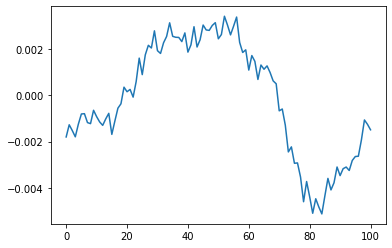

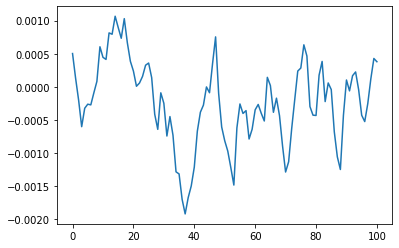

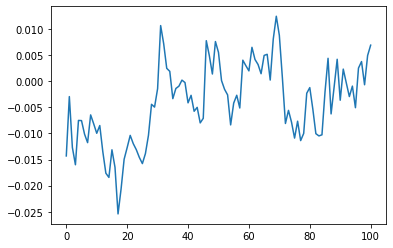

1


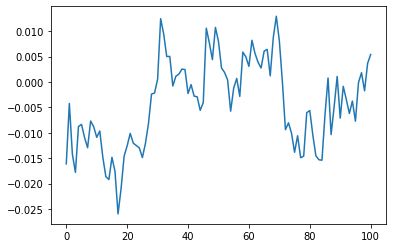

In [244]:
k = 1
m = 38
tmp_ac = th_ac.copy()
tmp_ni = th_ni.copy()

newdata = np.squeeze(tmp_ac[k,:]) # Shape is now: (10, 80)
plt.plot(newdata) # plotting by columns
plt.show()

newdata = np.squeeze(tmp_ni[k, :]) # Shape is now: (10, 80)
plt.plot(newdata) # plotting by columns
plt.show()

newdata = np.squeeze(tX[m, k, :]) # Shape is now: (10, 80)
plt.plot(newdata) # plotting by columns
plt.show()
print(ty[m])

if ty[m] == 1: 
  after_tune = tX[m] + tmp_ac
else: 
  after_tune = tX[m] + tmp_ni
plt.plot(after_tune[k, :]) # plotting by columns
plt.show()

In [271]:
cnn_model = Sequential()
cnn_model.add(Conv2D(8, kernel_size=(4, 40),activation='relu',input_shape=(10,101,1),padding='same'))
# cnn_model.add(MaxPooling2D((2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(16, (4, 80), activation='relu',padding='same'))
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (4, 80), activation='relu',padding='same'))         
# cnn_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
cnn_model.add(BatchNormalization(trainable = True))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(2, activation='sigmoid'))

cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_57 (Conv2D)          (None, 10, 101, 8)        1288      
                                                                 
 batch_normalization_46 (Bat  (None, 10, 101, 8)       32        
 chNormalization)                                                
                                                                 
 dropout_54 (Dropout)        (None, 10, 101, 8)        0         
                                                                 
 conv2d_58 (Conv2D)          (None, 10, 101, 16)       40976     
                                                                 
 batch_normalization_47 (Bat  (None, 10, 101, 16)      64        
 chNormalization)                                                
                                                                 
 dropout_55 (Dropout)        (None, 10, 101, 16)     